# Scraping ishares.com for index constituents

## 1. Preamble
For equity worflows and whenever an algorithm needs to be tested, it might be usefull to define an investment universe. The definition of an investment universe is a necessary part of the backtest process since the algorithm might not be suited to all stocks due to their underlying factor sensitivities. Some of these factors could include:

- Size (having a direct impact on liquidity)
- Newsflow activity (having a direct impact on Open Source Intelligence (OSINT) availability)
- Availability of implementation vehicles to act on trading signals (smaller stocks less derivatives, less exchanges available)

Unfortunately having access to high quality Investment Universes is generally made available by Index Providers at a substantial cost. As such traditional webscraping techniques can provide a usefull ally to gather index data at a zero cost price point.


This Notebook will walk you through:

- How to scrap ishares.com for ETFs
- How to use the output of this activity to download holdings for a given list of ETFs

For more background information on this Notebook, please consult the following article published on Medium ->

## 2. Imports
- datetime: date formating
- time: used for sleep functions to avoid being banned by the target
- random: used for random number generation when defining sleep period
- re: regular expressions when parsing specific data
- os: file system interactions (when downloading .xlsx files with ETF holdings)
- requests: for http interactions
- beautifulsoup: for html parsing
- polars: Rust implementation of dataframes for Python

In [ ]:
from datetime import datetime
import time
import random
import requests
from bs4 import BeautifulSoup
import polars as pl
import os
import sqlite3
import re

# 3. Strategy

#### A. SCRAP THE ETF SCREENER
-> https://www.ishares.com/uk/individual/en/products/etf-investments

- When visiting the ishares.com webpage, the user can decide to use the "ETF screener" to find a specific investment product.
- The user selects specific fields in the screener to restric the choice of products available
- Fields can include FX, Asset Class, Domicile
- Since we're based in Europe we focused on the Irish Umbrella Cny which holds the bulk of the products

Acquisition target -> Links to the product pages
Filters -> focus only on Irish Listed vehicle

#### B. SCRAP THE PRODUCT PAGE
- Upon selecting a product in the screener, the user is sent to the product page
- This product page contains additional information about the product characteristics
- Of particular interest if the "Physical replication" field which indicates that the ETF is constructed using physical replication hence trying to match as closely as possible the underlying stocks in the index. 
- The product also includes a link to the xlsx file containing the holdings.

Acquisition Target -> Instruments that are managed through physical replication & link to underlying holdings spreadsheet.


#### C. DOWNLOAD UNDERLYING HOLDINGS OF THE INSTRUMENT

- Once we have scrapped the product page for ETFs of interest we can iterate through the links pointing to the underlying spreadsheet and download these with the requests library.
- Per previous test the file name is usually a pretty poor descriptor of the product, as such we will also modify it to the full product name.

## 4. Scrapping of the ETF Screener
#### 4.1 Making the call through requests

In [ ]:
#Specifying URL
url = 'https://www.ishares.com/uk/professional/en/products/etf-investments'

headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"}

params = {
    'switchLocale' : 'y',
    'siteEntryPassthrough' : 'true',
    'productView': 'all',
    'domicile' : 'Ireland',
    'sortColumn' : 'totalFundSizeInMillions',
    'sortDirection' : 'desc',
    'dataView' : 'keyFacts',
    'keyFacts' : 'totalFundSizeInMillions',
    'showAll' : 'true'
}
response = requests.get(url, headers=headers, params=params)
# Uncomment to see output
#print(response.text)

Upon scrolling in the HTML response object, one will identify the data structure used to pass ETF data to the on page ETF screener dashboard

```
<tr>
 <th class="header-line">Ticker</th>
 <th class="header-line">Fund Name</th>
 <th class="header-line">Share Class Currency</th>
 <th class="header-line">Share<br/>Class</th>
 <th class="header-line">Distribution<br/>Type</th>
 <th class="header-line">TER (%)</th>
 <th class="header-line">AUM<br/>(M)</th>
 <th class="header-line">As Of</th>
 <th class="header-line">Domicile</th>
 <th class="header-line">Distribution<br/>Yield</th>
 </tr>
```

In [ ]:
# The data is held in the table tag. "Thead" (table head) holds the data Schema
# The other Thead tag holds the rest of the data
soup = BeautifulSoup(response.content, 'html.parser')
soup.thead

#### 4.2 Parsing the HTML reponse with BS4

We have the foresight of the data schema and fortunately these fields are fairly standard. As such:
- We can create lists of elements that are expected to come up in the schema
- Alternatively for less standard data we can create a regular expression to match potential content
- As we parse through the data we can verify if each element falls inside the schema

In [ ]:
## First we prepare a few fields...

# List of currencies
currency = ['USD', 'EUR', 'GBP', 'JPY','SEK', 'NZD','MXN','SGD', 'AUD', 'NOK', 'CHF']

# List of fund domicile
domicile = ['Ireland', 'Luxembourg', 'United Kingdom','Germany', 'United States']

# Share type
share_type = ['Accumulating', 'Distributing','No Income']

#ISIN Code Pattern matching
isincode_pattern = r"[A-Z]{2}[A-Z0-9]{9,10}\b"

# Share class pattern matching
share_class_pattern = r"\b(class|hedged)\b"

# Date pattern matching
date_pattern = r"^(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{1,2},\s\d{4}$"

Time for some ugly code... Since the tags are not too specialised we can't select precisely each field. We have to iterate trough a group of tags and then map the content based on the values extracted.

- We will create a list
- Append the list with dictionaries which for each etf include:
    - record id -> incremental number of ETF processe
    - link -> Link to the ETF product page
    - ticker -> Bloomberg ticker of the product
    - fund_name -> ETF product name
    - currency -> share class currency
    - share_type -> Distributing, Accumulating, Else..
    - 'TER' -> Product total expense ratio
    - updated_on -> Last update 
    - domicile -> Country of listing
    - yield -> Product yield if distributing

In [ ]:
#Instantiating empty list 
data_list = []

#Parsing the html object looking for tag 'tr' which is the "table row container" holding ETF data
soup = BeautifulSoup(response.content, 'html.parser')
trs = soup.find_all('tr')

#Start at one
record_id = 1

for row in trs[1:]:
    
    # Creating the empty ETF dict.
    data_dict = {}

    #Instantiating the nested dictionary with record_id
    data_dict['record_id'] = record_id

    # Links to product pages are possess a class atribute as such we isolate those
    td_link = row.find_all('td', class_='links')

    #Fetching Link, Ticker (if available), fund name
    # For some reason some products have two td lines with class attributes, others only one...
    # We hence need to cases
    if len(td_link) > 1:
        link = td_link[0].a['href']
        ticker = td_link[0].a.get_text(strip=True)
        fund_name = td_link[1].a.get_text(strip=True)
    elif len(td_link) == 1:
        link = td_link[0].a['href']
        ticker = False
        fund_name = td_link[0].a.get_text(strip=True)

    # Updating dictionary with the data we just parsed
    data_dict['link'] = 'http://www.ishares.com' + link # Links are stripped from first part of URL -> we add it back
    data_dict['ticker'] = ticker
    data_dict['fund_name'] = fund_name
    
    
    # Grabbing the rest of the data
    # It is held in td tags with a column-left-line attribute
    tds_col = row.find_all('td', class_='column-left-line')

    # Since the data is not tagged precisely we iterate through each ('td', class_='column-left-line')
    # then map data in a specific key/value pair inside the dictionary
    for i in range(0,len(tds_col)):

        content =  tds_col[i].get_text(strip=True)

        try:
            value = float(content)
            if value < 1:
                data_dict['TER'] = value
            elif value > 50 :
                data_dict['AUM'] = value
            elif value > 1 and value < 50:
                data_dict['yield'] = value
        except:
            pass
        
        if re.match(share_class_pattern, content, re.IGNORECASE):
            data_dict['share_class'] = content
        elif re.match(isincode_pattern, content):
            data_dict['ISIN'] = content
        elif content in domicile:
            data_dict['domicile'] = content
        elif content in currency:
            data_dict['currency'] = content
        elif content in share_type:
            data_dict['share_type'] = content
        elif re.match(date_pattern, content):
            data_dict['updated_on'] = content
    
    data_list.append(data_dict)
    record_id += 1

# Uncomment to see output
#data_list

#### 4.3  Exporting Target for analysis via polars data frame (optional)

In [ ]:
## Specify the data types for columns
dtypes = {
    'record_id' : pl.Int64,
    'link' : str,
    'ticker': str,
    'fund_name': str,
    'currency': str,
    'share_type': str,
    'share_class': str,
    'updated_on': str,
    'domicile': str,
    'ISIN' : str,
    'TER': float,
    'yield': float
}

# Loading data in the data frame
df = pl.DataFrame(data_list, schema=dtypes)

# Converting date strings to a "date data type"
df = df.with_columns(pl.col('updated_on').str.strptime(pl.Date, "%b %d, %Y"))

#Exporting data as CSV
df.write_csv('output.csv')
df.head()

# 5. Scrapping of the product pages

We face a few issues:
 - The product pages for funds listed in the US are different from the ones listed in ireland (different tags)
 - Depending on the product similar tags can be located either to the left or to the right of the column in the Key Facts table
 - For some reason ishares also includes "index funds" (not only ETFs) in the results of the screener (yet no tag exists in the data to differenciate them - we could have parsed the fund name and excluded those with "fund").
 - These index funds have different tags, and incomplete holdings (since they are not required by law to publish them.)

 



Sample characteristics of an ETF on the product page
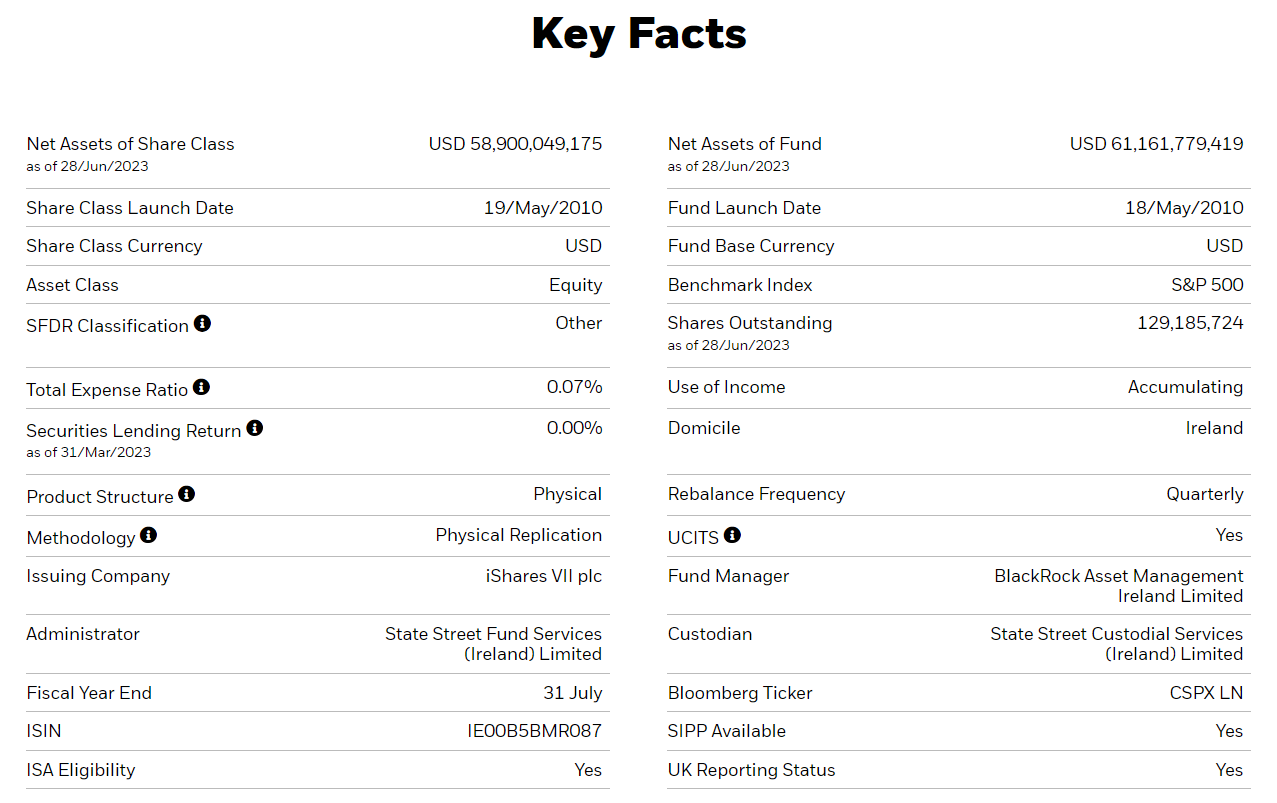

#### 5.1 Filtering the list of dictionaries scrapped from the ETF screener
- From the activity in section 4, we obtained a list of dictionaries
- Each dictionary constituting a instance of an ETF with link to product pages as well as other data

We choose to select ETFs listed in Ireland (Blackrock's main Umbrella company in Europe for ETFs)

In [ ]:
# Instanciating a new empty list
ireland_registered = []

# Iterating through dictionaries in the ETF screener scrapped output to single out ETFs listed in Ireland
for dict in data_list:
    try:
        if dict['domicile'] == "Ireland":
            ireland_registered.append(dict)
        else:
            pass
    except:
        pass

In [ ]:
# Passing the output to a Polars dataframe for analysis (optional)
df_ireland_listed = df.filter((pl.col('domicile') == 'Ireland'))
df_ireland_listed.write_csv('df_ireland_listed.csv')
df_ireland_listed.head()

#### 5.2 Creating functions for scrapping the ETF Product page

**A. Definition of the get_page function**
- We create the function "get_page" which takes the link to the ETF product page as an argument
- The return object is a Beautiful Soup container hosting the ETF product page html code (which we can then parse)

**B. Definition of the scrap_product function**
- We create the function "scrap_product" which takes 3 arguments: 
    - the beautiful soup return object
    - A list of target html tags (with classes)
    - A list with nested dictonaries of ETF products
- The function returns a dictonaries with 

**C. Specifying a list of tupples containing target tags & classes**
- These will be used by the scrap_product function to find the required data in the page

**D. Amended data schema (key value pair for each ETF)**
- net_assets_share_class
- share_class_currency
- share_class_launch_date
- net_assets_fund
- base_currency
- fund_launch_date
- asset_class
- benchmark_index
- benchmark_ticker
- ter
- use_of_income
- domicile
- product_structure
- methodology
- rebalance_frequency
- ucits
- fund_manager
- fund_house
- custodian
- bloomberg_ticker
- isin

In [ ]:
#<do not run this example cell>
# Example of what the code grabbing data associated to a specific tag looks like
# in this example we're looking for 'net_assets_fund'
# this code is fed the list of target tags as part of the scrap_product function

# parse the page to find the target tag 
div = soup.find('div', class_='float-left in-right col-totalNetAssetsFundLevel')
#navigate to a child element hosting the data
data =  div.find('span', class_='data').get_text(strip=True)
data

To run the above work flow we:

1. instanciate an empty list which will host data for the dictionaries of each etf
2. iterate through the list of dictionaries containing ETFs listed in ireland (step 5.1)
3. run get_page
4. run scrap_product (which will append a dictionary to the list)
5. wait 10-30 seconds before sending another donwload query to the server



In [ ]:
# get_page function
def get_page(webpage_link):

    # pretending we're a webbrowser
    headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"}

    # skipping the cookies stuff
    params = {
        'switchLocale' : 'y',
        'siteEntryPassthrough' : 'true',
    }
    
    # response object and parsing
    response = requests.get(webpage_link, headers=headers, params=params)
    soup = BeautifulSoup(response.content, 'html.parser')

    return soup

In [ ]:
# scrap_product function

def scrap_product(product_page, scrap_tags, screener_dict):
    
    # Instanciating the empty dict which will host 
    product_characteristics = {}
    # Adding fund name
    product_characteristics['fund_name'] = screener_dict['fund_name']   
    # Adding link to product page
    product_characteristics['product_link'] = screener_dict['link'] 

    ## Looping through the target tags and classes to fetch the data on the page
    for tup_key, value in scrap_tags:
            
            try:
                div = product_page.find('div', class_=value)
                data =  div.find('span', class_='data').get_text(strip=True)
            
                # Create the key with a value
                if tup_key not in product_characteristics:
                    product_characteristics[tup_key] = data
            
                # Replace the value if it is None
                elif product_characteristics[tup_key] == 'null':
                    product_characteristics[tup_key] = data
            
            except:
                # If the data cannot be found in the HTML code
                # but a key already exists in the dictionary we pass
                if tup_key in product_characteristics:
                    pass
                # If the data cannot be found in the HTML code
                # and a key does not exist in the dictionary we set the value to 'null'
                else:
                    product_characteristics[tup_key] = 'null'
            
    # We parse the HTML code for the link to the Holdings spreadsheet
    holdings_link = product_page.find('a', class_='icon-xls-export', attrs={'data-link-event': 'fund download:common'}).get('href')
    
    # For some reasons links in the webpage do not include 'https://www.ishares.com' in front so we need to add it back 
    product_characteristics['holdings_link'] = 'https://www.ishares.com' + holdings_link

    # Define the name we will use to name the spreadsheet when downloading it
    product_characteristics['file_name'] = screener_dict['fund_name'] + '.xls'
    
    return product_characteristics

In [2]:
# Depending on the ETF the data can be located either on the left column or right column of the HTML form
# We therefore need to specify both cases for each target.
scrap_tags = [('net_assets_share_class' , 'float-left in-left col-totalNetAssets'),
                ('net_assets_share_class' , 'float-left in-right col-totalNetAssets'),
                ('share_class_currency' , 'float-left in-left col-seriesBaseCurrencyCode'),
                ('share_class_currency' , 'float-left in-right col-seriesBaseCurrencyCode'),
                ('share_class_launch_date' , 'float-left in-left col-inceptionDate'),
                ('share_class_launch_date' , 'float-left in-right col-inceptionDate'),
                ('net_assets_fund' , 'float-left in-left col-totalNetAssetsFundLevel'),
                ('net_assets_fund' , 'float-left in-right col-totalNetAssetsFundLevel'),
                ('base_currency' , 'float-left in-left col-baseCurrencyCode'),
                ('base_currency' , 'float-left in-right col-baseCurrencyCode'),
                ('fund_launch_date' , 'float-left in-left col-launchDate'),
                ('fund_launch_date' , 'float-left in-right col-launchDate'),
                ('asset_class' , 'float-left in-left col-assetClass'),
                ('asset_class' , 'float-left in-right col-assetClass'),
                ('benchmark_index' , 'float-left in-left col-indexSeriesName'),
                ('benchmark_index' , 'float-left in-right col-indexSeriesName'),
                ('benchmark_ticker' , 'float-left in-left col-benchmarkTicker'),
                ('benchmark_ticker' , 'float-left in-right col-benchmarkTicker'),
                ('ter' , 'float-left in-left col-emeaMgt'),
                ('ter' , 'float-left in-right col-emeaMgt'),
                ('use_of_income' , 'float-left in-left col-useOfProfitsCode'),
                ('use_of_income' ,'float-left in-right col-useOfProfitsCode'),
                ('domicile' , 'float-left in-left col-domicile'),
                ('domicile' , 'float-left in-right col-domicile'),
                ('product_structure' , 'float-left in-left col-productStructure'),
                ('product_structure' , 'float-left in-right col-productStructure'),
                ('methodology' , 'float-left in-left col-fundMethodologyTypeCode'),
                ('methodology' , 'float-left in-right col-fundMethodologyTypeCode'),
                ('rebalance_frequency' , 'float-left in-left col-rebalanceFrequency'),
                ('rebalance_frequency' , 'float-left in-right col-rebalanceFrequency'),
                ('ucits' , 'float-left in-left col-ucitsCompliantFlag'),
                ('ucits' , 'float-left in-right col-ucitsCompliantFlag'),
                ('fund_manager' , 'float-left in-left col-fundmanager'),
                ('fund_manager' , 'float-left in-right col-fundmanager'),
                ('fund_house' , 'float-left in-left col-issuingCompany'),
                ('fund_house' , 'float-left in-right col-issuingCompany'),
                ('custodian' , 'float-left in-left col-fundCustodian'),
                ('custodian' , 'float-left in-right col-fundCustodian'),
                ('bloomberg_ticker' , 'float-left in-left col-bbeqtick'),
                ('bloomberg_ticker' , 'float-left in-right col-bbeqtick'),
                ('isin' , 'float-left in-left col-isin'),
                ('isin' , 'float-left in-right col-isin')
]

#### 5.3 Scrapping the product pages

In [ ]:
# Instanciating a list to host dictionaries
scrap = []

# Looping through the ETFs listed in Ireland.
for dict in ireland_registered:
    
    # Snatching the link to the product page
    product_page = dict['link']

    # get_page function to get html object
    page = get_page(product_page)
    # scrap_product to scrap data of the page
    scrap_dict = scrap_product(page, scrap_tags, dict)
    # append scrapped data to the list
    scrap.append(scrap_dict)

    # Generate a random sleep duration between 10 and 20 seconds
    # to be server friendly...
    sleep_duration = random.randint(10, 20)
    print("Sleeping for", sleep_duration, "seconds...")
    time.sleep(sleep_duration)

#### 5.4 Pass data to a polars data frame and export to CSV (optional)

In [ ]:
df_scrap = pl.DataFrame(scrap)
df_scrap.write_csv('df_scrap.csv')
df_scrap.head()

# 6. Dowloading all the holdings spreadsheets

In [ ]:
#1. Modules############################################################
import polars as pl # <- polars dataframes like pandas but cooler (i.e icy)
import requests # <- interacting with web stuff
import os # <- interacting with directories
import time # <- be gentle with the server
import random
#######################################################################

#2. Setting up fodlers...
current_directory = os.getcwd()
subdirectory_name = "holdings_download"
subdirectory_path = os.path.join(current_directory, subdirectory_name)
os.makedirs(subdirectory_path, exist_ok=True)

#3. Import the csv in a polars dataframe
df = pl.read_csv('df_scrap.csv')

#4. Tupple instanciation for filtering ETF run through physical replication.
to_include = ('Replicated','Physical Replication')

#5. Filtering the data frame
df_filtered = df.filter((pl.col('domicile') == 'Ireland') &
                              (pl.col('product_structure') == 'Physical') &
                              (pl.col('benchmark_index') != 'null') &
                              (pl.col('methodology').is_in(to_include))
                              )

#6. Pretending we're a webbrowser...
headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"}

#7. Passing holdings_links and file_name to a list of dictionaries
filtered_list = df_filtered.select(['holdings_link','file_name']).to_dicts()

#8. Snatching the loot...
for dictionary in filtered_list:
   
   response = requests.get(dictionary['holdings_link'], headers=headers)
   file_path = os.path.join(subdirectory_path, dictionary['file_name'])
   
   if response.status_code == 200:
   
      with open(file_path, 'wb') as file:
         file.write(response.content)
         print(f"File downloaded successfully: {file_path}")
   
   else:
      print(f"Failed to download file to : {file_path}")

   sleep_duration = random.randint(5, 10)
   print("Sleeping for", sleep_duration, "seconds...")
   time.sleep(sleep_duration)